In [270]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import keras
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from data import generate_synthetic_dataset_easy
from Plotting.Plot import BasicPlot, MultiPlot
tf.compat.v1.enable_eager_execution()
import scipy
import pandas as pd
import seaborn as sns
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 0.5

tf.random.set_seed(None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
@tf.function
def get_fim(model, inputs, outputs):
    jac = []
    with tf.GradientTape(persistent=True) as t2:
        with tf.GradientTape() as t1:
            t2.watch(model.trainable_variables)
            t1.watch(model.trainable_variables)
            loss = tf.keras.losses.KLDivergence(keras.losses.losses_utils.ReductionV2.NONE)
            loss = loss(outputs, model(inputs))
            grads = t1.gradient(loss, model.trainable_variables)
        for i in range(len(grads)):
            jac.append(t2.jacobian(grads[i], model.trainable_variables[i]))
            t2.reset()
    return grads, jac, loss


n_features = 8
n_classes = 2

def get_model(n_features=n_features, n_classes=n_classes, n_layers=0, use_bias=False):
    model = keras.Sequential([
        keras.layers.Dense(n_features, activation='relu', use_bias=use_bias),
        *[keras.layers.Dense(n_features, activation='relu', use_bias=use_bias) for _ in range(n_layers)],
        keras.layers.Dense(n_classes, activation='softmax', use_bias=use_bias)])
    return model

(x_train, y_train), (x_test, y_test) = generate_synthetic_dataset_easy(num_datapoints=100, n_features=n_features, n_classes=n_classes)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

n_iter = 10
grads = []
jacs = []
losses = []
for i in range(n_iter):
    model = get_model()
    inputs = np.random.uniform(-1, 1, size=x_train.shape)
    outputs = model(np.random.uniform(-1, 1, size=x_train.shape))
    grad, jac, loss = get_fim(model, inputs, outputs)
    grads.append(grad)
    jacs.append(jac)
    losses.append(loss)

num_layers = len(model.trainable_variables)

means = np.zeros((num_layers, 3, 1), dtype=object)
for n in range(num_layers):
    for i in range(n_iter):
        means[n, 0, 0] += grads[i][n]
        means[n, 1, 0] += jacs[i][n]
        means[n, 2, 0] += losses[i][n]
    means[n, 0, 0] /= n_iter
    means[n, 1, 0] /= n_iter
    means[n, 2, 0] /= n_iter

grads = means[:, 0, 0]
jac = means[:, 1, 0]
loss = means[:, 2, 0] 

jac2 = np.outer(grads, grads)
print(f'Jac2: {jac2.shape}')
print(f'Loss: {loss.shape}')
for i in range(len(grads)):
    print(f'Grad {i}: {grads[i].shape}')
    jac[i] = tf.concat(jac[i], axis=0)
    print(f'Jac: {jac[i].shape}')


eigvals = np.linalg.eigvals(tf.transpose(jac2)).real
print(f'Mean: {np.mean(eigvals)}, Max: {np.max(eigvals)}, Min: {np.min(eigvals)}, STD: {np.std(eigvals)}')
print(f'Shape: {eigvals.shape}')
sns.histplot(eigvals.flatten(), bins=10)

TypeError: unsupported operand type(s) for +=: 'int' and 'NoneType'

# Second Method
Taken from https://github.com/amyami187/effective_dimension/blob/v1.0.0/effective_dimension/classical_nn.py

[ 1.99042399e-08 -2.02173518e-08  2.15082201e-08 -5.25322951e-09
  2.80527044e-09 -1.97636010e-08  1.01197161e-08 -1.73528180e-08
  1.63553350e-08  2.01230139e-08  1.12491894e-08 -4.66065245e-09
  1.62584297e-08  1.30517148e-08 -7.09470553e-09  2.27980482e-08
  2.00883269e-08  3.99541509e-09  4.25439521e-09  1.05377003e-08
  3.48111386e-09  1.19141514e-08 -1.15554932e-08  1.13782586e-09
 -1.22856572e-08 -1.49734086e-08  1.29762990e-08 -1.35693250e-08
  5.05403448e-09  7.40380046e-10  2.70001484e-08  1.26699545e-08
 -1.09576004e-08 -4.49294557e-10 -2.73542572e-09 -1.47395464e-08
  1.25151727e-08 -3.58743746e-09 -1.24277729e-08  1.96256829e-08
 -1.06955163e-08  2.11275028e-08  2.43970617e-09 -9.82476742e-09
  7.85332697e-09  1.20895111e-08 -1.10597960e-08  5.60815374e-09
  4.80355126e-09  1.01598329e-08 -9.21763070e-09 -3.10971486e-09
 -4.15367731e-09 -1.14118348e-08  5.81052895e-10 -1.68669817e-08
  1.07753924e-08  2.42699727e-09  1.32647866e-08  1.21477351e-08
  9.01144994e-09 -4.24159

<Axes: ylabel='Count'>

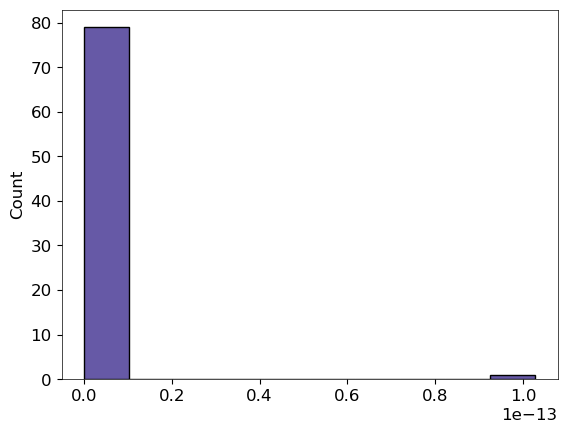

In [347]:
@tf.function
def get_grads(inputs, model):
    with tf.GradientTape() as t:
        t.watch(model.trainable_variables)
        outputs = model(inputs)
    return t.gradient(outputs, model.trainable_variables)

n_iter = 10


model = get_model()
inputs = np.random.uniform(-1, 1, size=x_train.shape)
outputs = model(inputs)

total_params = [inputs.shape[-1]] + [l.output_shape[1] for l in model.layers]
total_params = sum([total_params[i]*total_params[i+1] for i in range(len(total_params)-1)])
grads = np.zeros([n_iter, total_params])
for i in range(n_iter):
    model = get_model()
    inputs = np.random.uniform(-1, 1, size=x_train.shape)
    outputs = model(inputs)
    grad = get_grads(inputs, model)
    grads[i] = tf.concat([tf.reshape(g, [-1]) if g.ndim == 2 else g for g in grad ], axis=0)

grads = np.mean(grads, axis=0)
fishers = np.outer(grads, grads)
print(f'Inputs: {inputs.shape}')
print(f'Grad: {grads.shape}')
print(f'Fisher: {fishers.shape}')

eigvals = np.linalg.eigvals(tf.transpose(fishers)).real
print(f'Mean: {np.mean(eigvals)}, Max: {np.max(eigvals)}, Min: {np.min(eigvals)}, STD: {np.std(eigvals)}')
print(f'Shape: {eigvals.shape}')
sns.histplot(eigvals.flatten(), bins=10)